# Advanced Machine Learning - programming assignment 3

**Please fill in:**
* Davide Schiavi (6967620)
* Samuel Meyer (5648122)
* Riccardo Bassani (6866840)

## Reinforcement learning with function approximation
In this assignment, you'll design an agent to complete an episodic task. The agent will be looking at a small part of the UU logo, and will have to decide which of the four compass directions to move in, to find the goal in the center as soon as possible.

The following code defines various aspects of the environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, optimizers
from tqdm.notebook import tqdm # For progress bars

# Action space
ACTION_NORTH = 0
ACTION_EAST = 1
ACTION_SOUTH = 2
ACTION_WEST = 3
ACTIONS = [ACTION_NORTH, ACTION_EAST, ACTION_SOUTH, ACTION_WEST]

# Constants defining the environment
GOAL = (300, 276)
AVG_MOVEMENT_SIZE = 24

RADIUS = 72
BOUNDARY_WEST = GOAL[0] - RADIUS
BOUNDARY_EAST = GOAL[0] + RADIUS
BOUNDARY_NORTH = GOAL[1] - RADIUS
BOUNDARY_SOUTH = GOAL[1] + RADIUS

WINDOW_SIZE = 28

TIME_LIMIT = 200
TIMEOUT_REWARD = -10.0

im = plt.imread("UU_logo_EN_CMYK.png")

# Convert to one color channel (using only the red channel), with white background
im = im[:,:,0] * im[:,:,3] + (1.0 - im[:,:,3])

# Get a "camera view" at the position indicated by state
# Use reshape=True to format the output as a data point for the neural network
def get_window(state, reshape=False):
    # When indexing the image as an array, switch the coordinates: im[state[1], state[0]]
    window = im[(state[1]-14):(state[1]+14), (state[0]-14):(state[0]+14)]
    if reshape:
        return np.reshape(window, (1, 28, 28, 1))
    else:
        return window

Using TensorFlow backend.


The following three images show:
* The original image, with a red dot marking the goal and a blue rectangle marking the area where the center of agent must remain. A movement that would take the agent outside this rectangle, places him at the boundary instead.
* What the agent sees if he is exactly at the goal.
* The part of the image the agent might see (this is slightly bigger than the blue box, because of the camera's size).

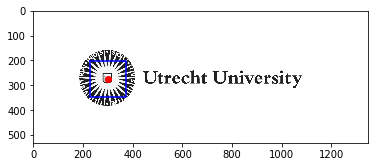

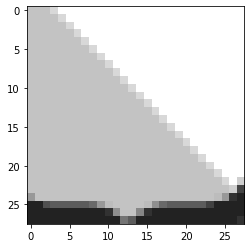

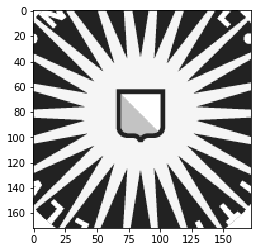

In [2]:
plt.imshow(im[:,:], cmap='gray', vmin=0, vmax=1.0)
# Plotting uses reversed y-axis now: larger y values are further down
plt.plot(GOAL[0], GOAL[1], 'ro', linewidth=5)
plt.plot([BOUNDARY_WEST, BOUNDARY_WEST, BOUNDARY_EAST, BOUNDARY_EAST, BOUNDARY_WEST],
        [BOUNDARY_NORTH, BOUNDARY_SOUTH, BOUNDARY_SOUTH, BOUNDARY_NORTH, BOUNDARY_NORTH],
        'b-')
plt.show()

# window around goal
plt.imshow(get_window(GOAL), cmap='gray', vmin=0, vmax=1.0)
plt.show()

plt.imshow(im[(BOUNDARY_NORTH-14):(BOUNDARY_SOUTH+14),(BOUNDARY_WEST-14):(BOUNDARY_EAST+14)], cmap='gray', vmin=0, vmax=1.0)
plt.show()

The following functions complete the definition of the environment. The agent's movements always go in the intended direction, but the distance travelled has a small random component.

Besides by reaching the goal, the episode also terminates after TIME_LIMIT (200) steps; at that point, the agent gets reward TIMEOUT_REWARD (-10).

In [3]:
# Take an action in a state
# Returns: new state, reward (always -1)
def step(state, action):
    x, y = state
    if action == ACTION_NORTH:
        y -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        if y < BOUNDARY_NORTH:
            y = BOUNDARY_NORTH
    elif action == ACTION_SOUTH:
        y += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        if y > BOUNDARY_SOUTH:
            y = BOUNDARY_SOUTH
    elif action == ACTION_WEST:
        x -= AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        if x < BOUNDARY_WEST:
            x = BOUNDARY_WEST
    elif action == ACTION_EAST:
        x += AVG_MOVEMENT_SIZE + np.random.randint(5) - 2
        if x > BOUNDARY_EAST:
            x = BOUNDARY_EAST
        
    reward = -1.0
    return (x, y), reward

# Is the state close enough to the goal to be considered a success?
# There is a margin for error, so that the agent can't jump over the goal
def is_goal_reached(state):
    if np.amax(np.abs(np.asarray(state) - np.asarray(GOAL))) <= AVG_MOVEMENT_SIZE / 2 + 1:
        return True
    else:
        return False
    
# Return a randomly chosen non-terminal state as starting state
def starting_state():
    while True:
        state = (np.random.randint(BOUNDARY_WEST, BOUNDARY_EAST + 1),
                 np.random.randint(BOUNDARY_NORTH, BOUNDARY_SOUTH + 1))
        if not is_goal_reached(state):
            return state

This class handles the function approximation, with several methods to query and update it. A linear function is used.

In [4]:
class LinearValueFunction:
    def __init__(self, step_size):
        self.step_size = step_size

        # Use a tile coding with only a single tiling (i.e. state aggregation):
        # a grid of square tiles
        self.tile_size = 16
        self.w = np.zeros(((BOUNDARY_SOUTH - BOUNDARY_NORTH + self.tile_size) // self.tile_size,
                           (BOUNDARY_EAST - BOUNDARY_WEST + self.tile_size) // self.tile_size,
                           4))

    # Return estimated action value of given state and action
    def value(self, state, action):
        if is_goal_reached(state):
            return 0.0
        return self.w[(state[1] - BOUNDARY_NORTH) // self.tile_size, (state[0] - BOUNDARY_WEST) // self.tile_size, action]

    # Return vector of estimated action values of given state, for each action
    def values(self, state):
        if is_goal_reached(state):
            return np.zeros(4)
        return self.w[(state[1] - BOUNDARY_NORTH) // self.tile_size, (state[0] - BOUNDARY_WEST) // self.tile_size, :]

    # learn with given state, action and target
    def learn(self, state, action, target):
         self.w[(state[1] - BOUNDARY_NORTH) // self.tile_size,
                (state[0] - BOUNDARY_WEST) // self.tile_size,
                action] += (
             self.step_size
             * (target
                - self.w[(state[1] - BOUNDARY_NORTH) // self.tile_size,
                         (state[0] - BOUNDARY_WEST) // self.tile_size,
                         action]))

    # Return estimated state value, based on the estimated action values
    def state_value(self, state):
        return np.max(self.values(state))

# Plot the state value estimates. Use a larger stride for lower resolution.
def plot_state_values(value_function, stride=1):
    v = np.zeros(((BOUNDARY_SOUTH - BOUNDARY_NORTH + stride) // stride,
                  (BOUNDARY_EAST - BOUNDARY_WEST + stride) // stride))
    for i, y in enumerate(range(BOUNDARY_NORTH, BOUNDARY_SOUTH + 1, stride)):
        for j, x in enumerate(range(BOUNDARY_WEST, BOUNDARY_EAST + 1, stride)):
            v[i,j] = value_function.state_value((x, y))
    plt.imshow(v)
    plt.colorbar()
    plt.show()

Next comes your part. The following two functions are responsible for the agent's behavior. First, get_action should implement the epsilon-greedy policy, and return an action chosen according to that policy.

In [5]:
# Choose action at state based on epsilon-greedy policy and valueFunction
def get_action(state, value_function, epsilon):
    choice = np.random.choice(["explore", "exploit"], p=[epsilon, 1-epsilon])
    if choice == "explore":
        action = np.random.choice(ACTIONS)
    elif choice == "exploit":
        state_values = value_function.values(state)
        action = np.argmax(state_values)    
    return action

The following function handles the interaction between agent and environment for a single episode. By passing the same value_function object in multiple calls to this function, the agent can learn from a sequence of such interactions.

Implement the missing parts of semi-gradient n-step Q-learning. This algorithm is almost exactly the same as the semi-gradient n-step Sarsa algorithm in section 10.2 of the book, except that the final term of $G$ should be computed as for Q-learning rather than as for Sarsa.

The main missing part is the computation of the update target. To be able to compute this, and to make the right call to value_function.learn, you'll also need to add code in other places in the function to keep track of previous states, actions and rewards. For full points, do this in a way that uses an amount of memory that depends on $n$, but not on the number of time steps the episode takes.

In [6]:
# Semi-gradient n-step Q-learning with approximation
# valueFunction: action value function to learn
# n: number of steps for multi-step TD
# epsilon: parameter of epsilon-greedy policy                       
# learning: should the value function be updated during the simulation?
from collections import deque 

def semi_gradient_n_step_q_learning(value_function, n=1, epsilon=0.0, learning=True):
    current_state = starting_state()
    # get initial action
    current_action = get_action(current_state, value_function, epsilon)

    # track the time
    time = 0

    # termination time
    T = float('inf')
    
    total_reward = 0.0
    
    # create a n-long structure to save the states
    state_memory = deque()
    # create a n-long structure to save the actions  
    action_memory = deque()
    # create a n-long structure to save the rewards   
    reward_memory = deque()
      
    
    while True:
        if time < T:
            # take current action and go to the new state
            new_state, reward = step(current_state, current_action)
            
            # memorize new values for current state, current action and reward
            state_memory.append(current_state)
            action_memory.append(current_action)
            reward_memory.append(reward)

            if is_goal_reached(new_state):
                T = time + 1
            elif time >= TIME_LIMIT:
                T = time + 1
                reward = TIMEOUT_REWARD
            else:
                # choose new action
                new_action = get_action(new_state, value_function, epsilon)
                            
            total_reward += reward

        # get the time index of the state to update
        update_time = time - n + 1
        if update_time >= 0 and learning:
            # Sum of all the rewards in memory + value of the current (state, action) couple            
            target = sum(reward_memory) + value_function.value(current_state, current_action)
            # update the value function
            value_function.learn(state_memory[0], action_memory[0], target)
            state_memory.popleft()
            action_memory.popleft()
            reward_memory.popleft()

        if update_time == T - 1:
            break
        # go to next time step
        time += 1
        if time < T:
            current_state = new_state
            current_action = new_action

    return total_reward

Now it's time to test the performance of the algorithm on the environment. Plot estimates of the return as a function of the episode, for a few combinations of the parameters $n$ and $\alpha$. A reasonable starting point for $\alpha$ is 1e-5.

The code is provided in the next cell, but to avoid the waiting necessary for the function to run, it is commented out and the obtained plots can be  printed running the successive cells.

In [7]:
# nValues = [1, 2, 4, 8, 12, 16, 32]
# episodes = 100
# repetitions = 10
# stepSizes = [0.0001, 0.001, 0.01, 0.1]

# for alpha in stepSizes:        
#     all_values = []
#     for r in range(repetitions):
#         values = [[0] * len(nValues) for k in range(episodes)]
#         for n_value in nValues:
#             valueFunction = LinearValueFunction(alpha)
#             for j in range(episodes):
#                 values[j][nValues.index(n_value)] = semi_gradient_n_step_q_learning(valueFunction, n=n_value, epsilon=0.01, learning=True)
#             del valueFunction
#         all_values.append(values)

#     avg_values = np.mean(all_values, axis=0)
#     plt.figure(figsize=(20,10))
#     plt.subplot()
    
#     avgs=[]
#     for i, n in enumerate(nValues):
#         avgs.append("n=" + str(n) + ", ret=" + str(round(np.mean(avg_values[-20:], axis=0)[i])))
        
#     plt.title("alpha = " + str(alpha))
#     plt.plot(avg_values, "o-")
#     plt.ylabel("Estimated Returns")
#     plt.xlabel("Episodes")
#     plt.legend(avgs, fontsize = 'xx-large')
#     plt.show()

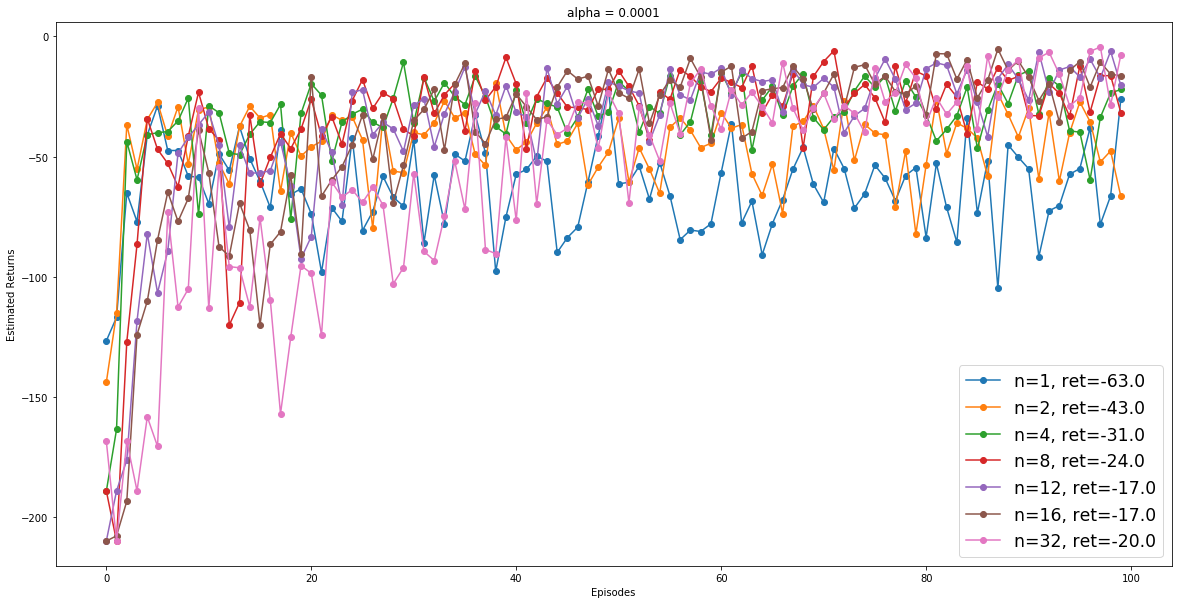

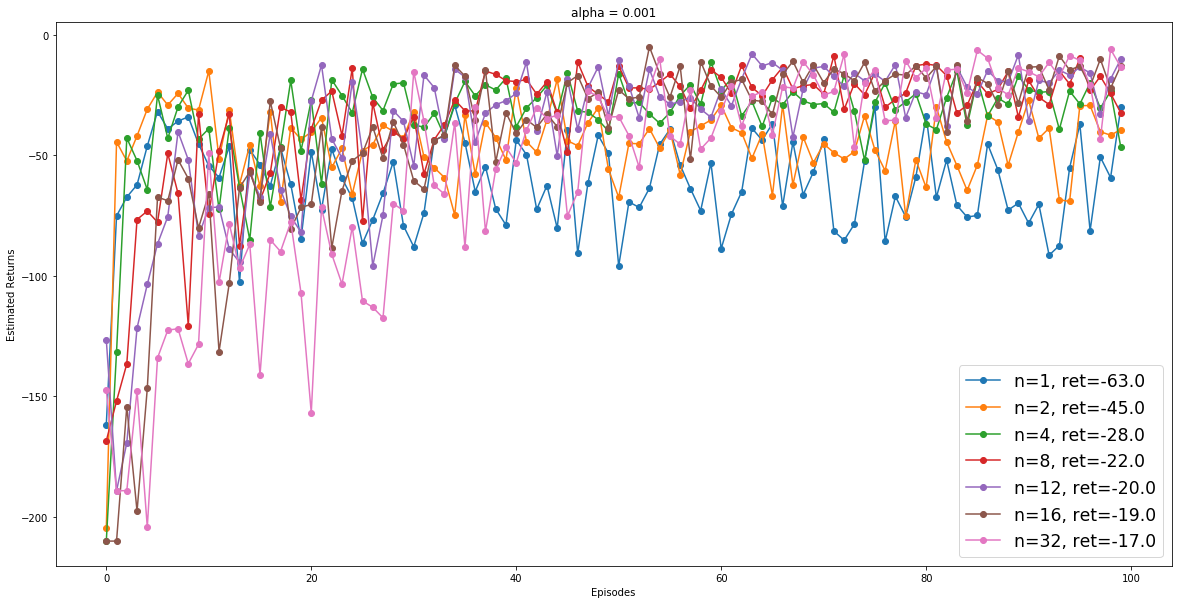

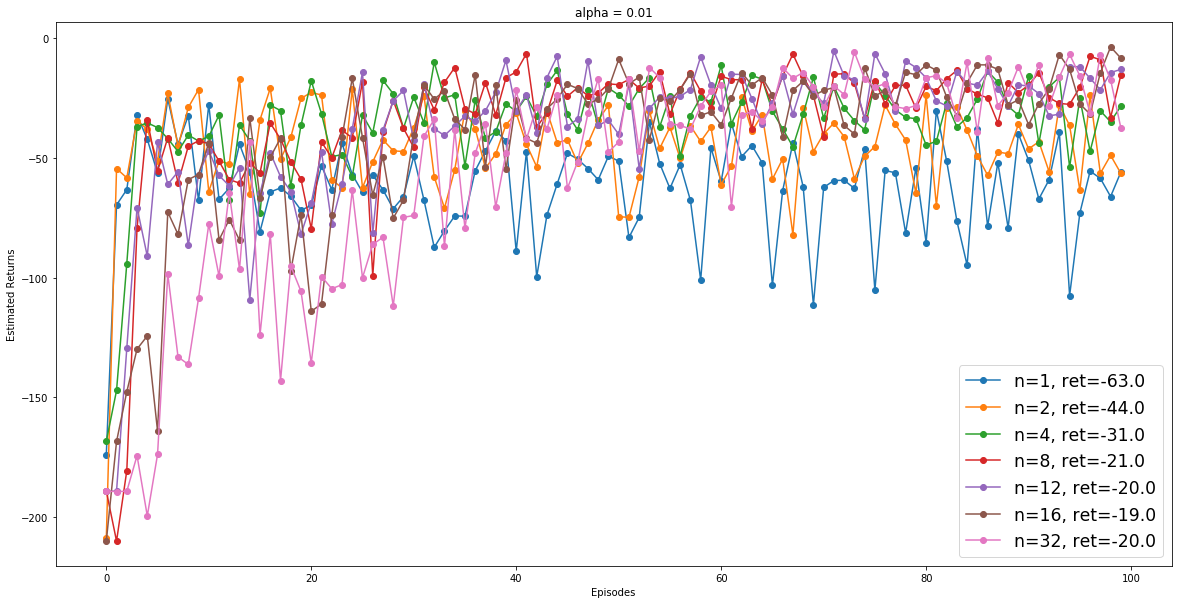

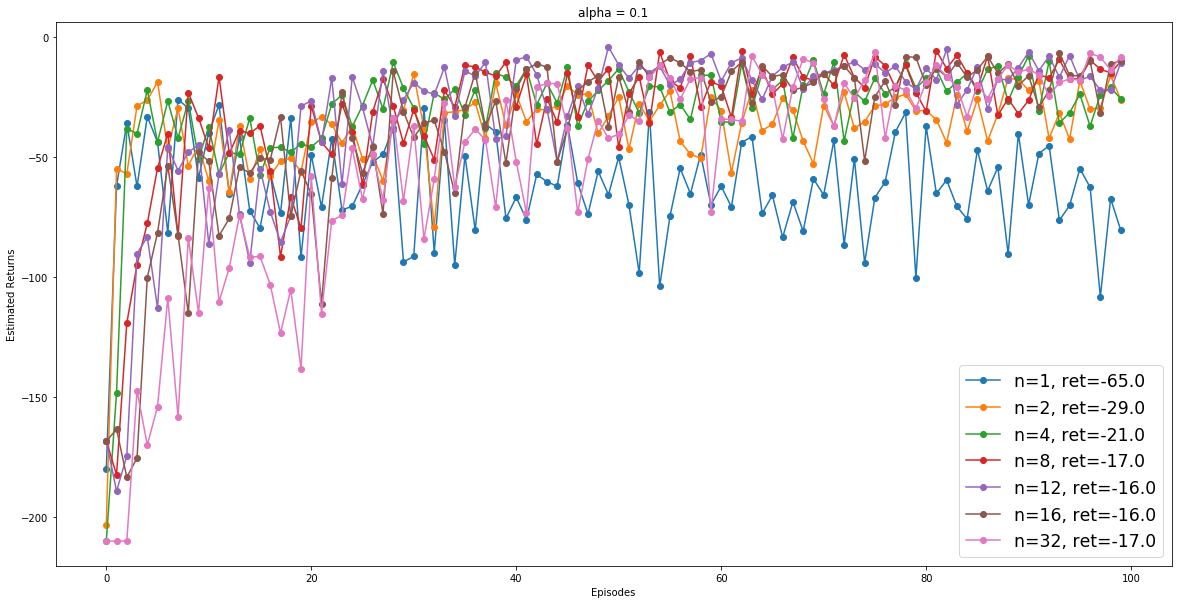

In [8]:
from IPython.display import display, Image
display(Image(filename='100ep_alpha-4.png'))
display(Image(filename='100ep_alpha-3.png'))
display(Image(filename='100ep_alpha-2.png'))
display(Image(filename='100ep_alpha-1.png'))

The results are averaged over 10 runs of 100 episodes. 
The best results are achieved for n = 8, 12, 16, 32, without being significantly affected by the value of alpha: after the first 80 episodes, the average return of the next 20 episodes is between -16 and -20 for the majority of the combination of alpha and n aforementioned (higher values of alpha yields slightly better results).

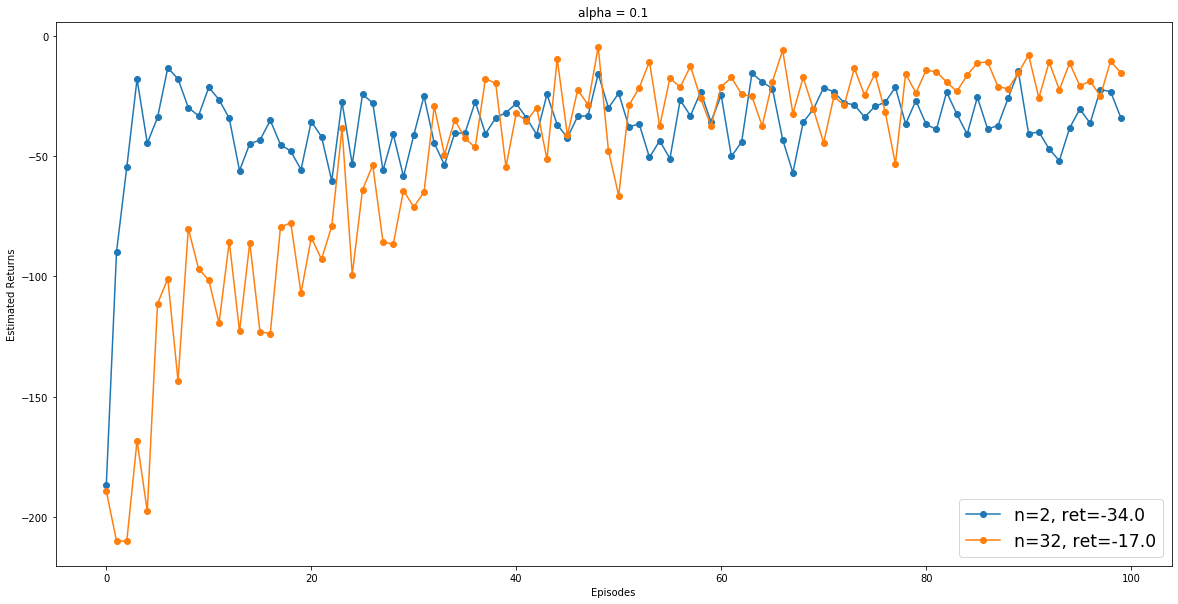

In [9]:
display(Image(filename='n_comparison.png'))

From the image above, it can be noticed even more clearly how, as expected, for larger values of n it takes more episodes for the variance to decrease and for the results to improve, but in the end better results are reached. Therefore, larger values of n are tested for 1000 episodes.

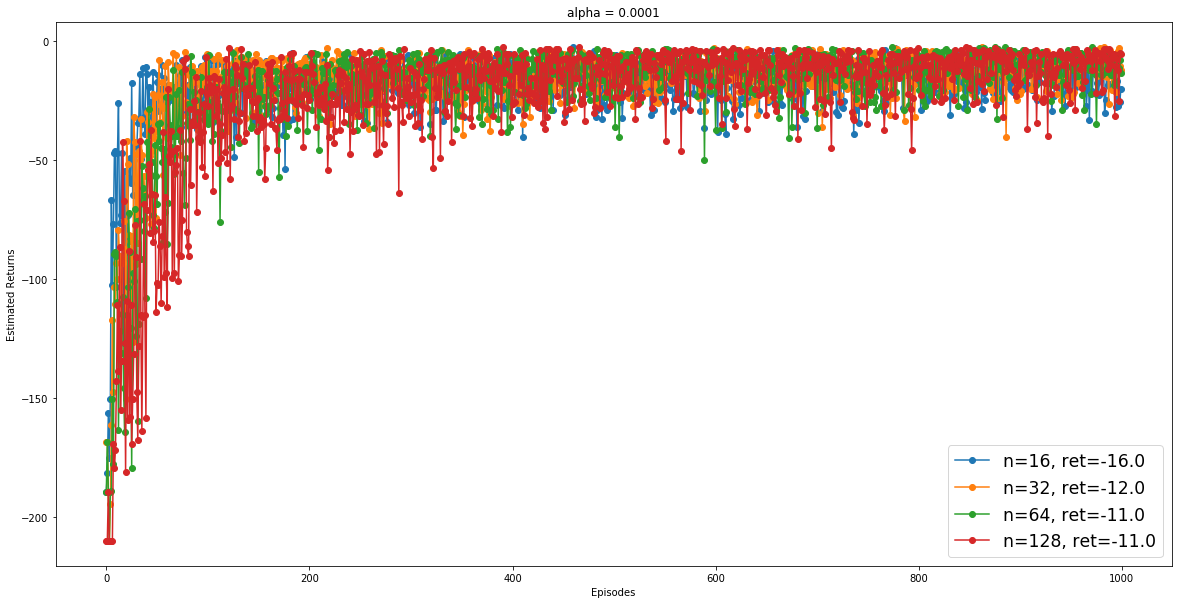

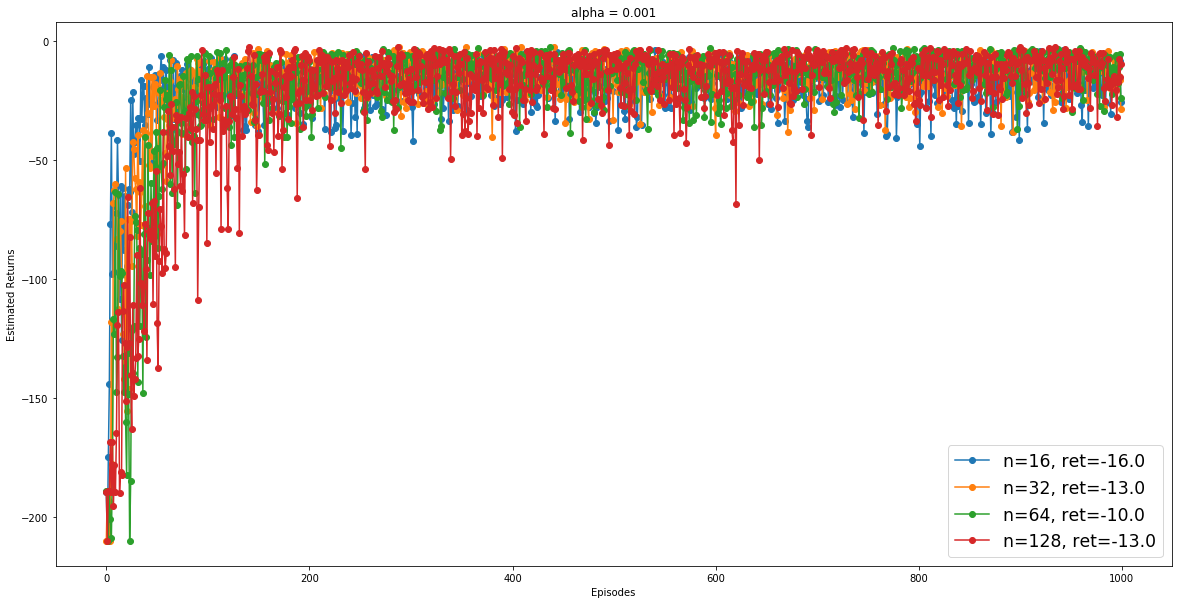

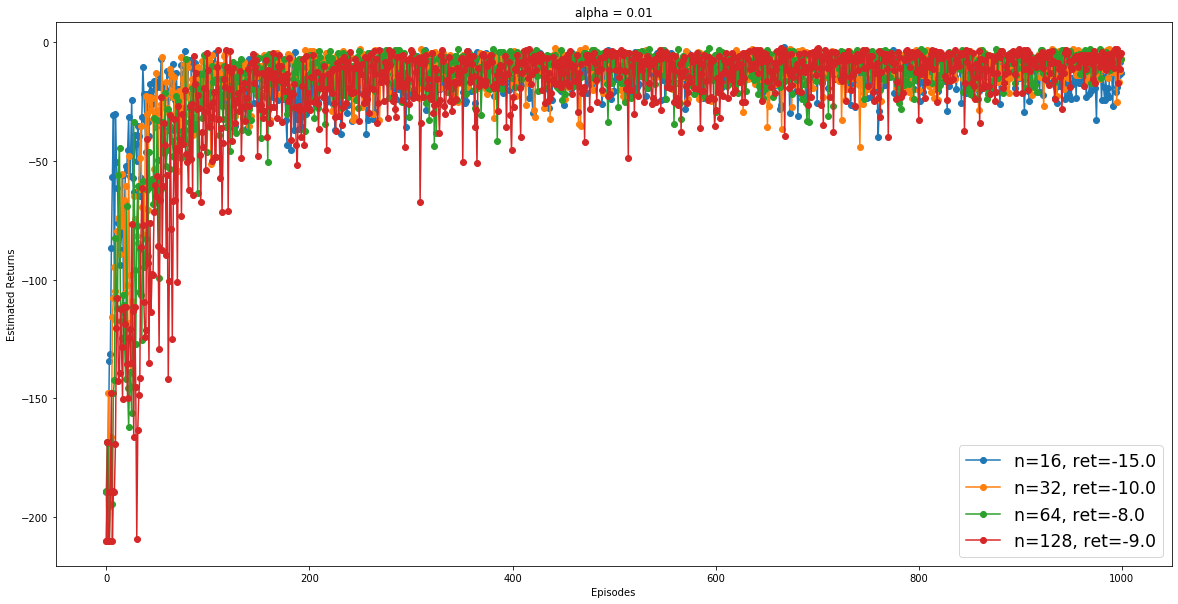

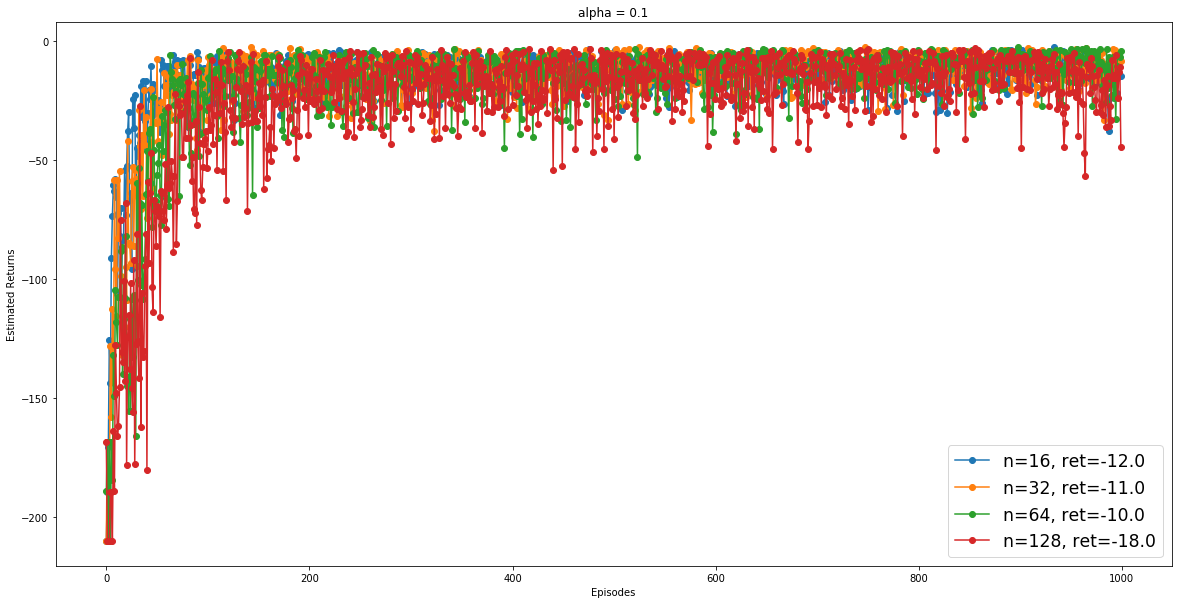

In [10]:
display(Image(filename='1000ep_alpha-4.png'))
display(Image(filename='1000ep_alpha-3.png'))
display(Image(filename='1000ep_alpha-2.png'))
display(Image(filename='1000ep_alpha-1.png'))

Also use your code to estimate the return of an agent that picks all actions uniformly at random.

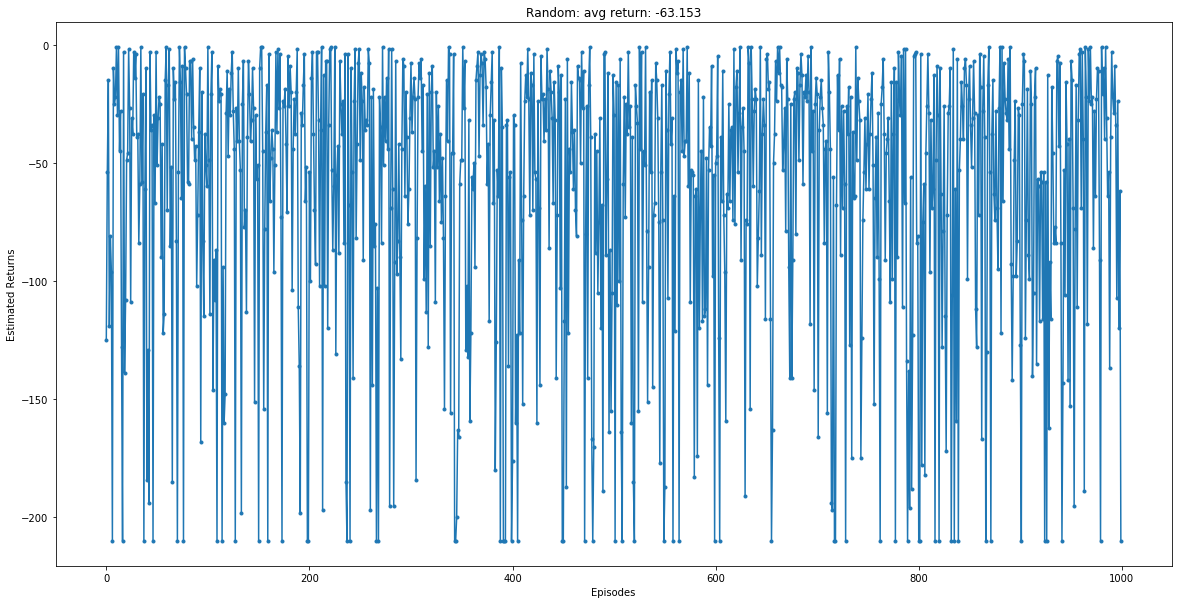

In [11]:
valueFunctionRan = LinearValueFunction(0.00001)
valuesRan = []
for i in range(1000):
    valuesRan.append(semi_gradient_n_step_q_learning(valueFunctionRan, n=2, epsilon=1, learning=False))

plt.figure(figsize=(20,10))
plt.plot(valuesRan, ".-")
plt.ylabel("Estimated Returns")
plt.xlabel("Episodes")
plt.title("Random: avg return: " + str(np.mean(valuesRan)))
plt.show()

Take the parameter values for which you saw the best performance. Are you satisfied with its performance? Use the plot_state_values function to get an idea of what is going on. Describe your observations in a few sentences.

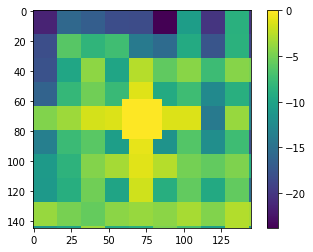

In [12]:
valueFunction = LinearValueFunction(0.01)
for i in range(1000):
    semi_gradient_n_step_q_learning(valueFunction, n=64, epsilon=0.01, learning=True)
plot_state_values(valueFunction, stride=1)

The results are averaged over 10 runs of 1000 episodes. 
The best result is achieved for n=64 and alpha = 0.01: after the first 900 episodes, the average return of the next 100 episodes is -8. This performance is still not optimal (in the worst case, starting from a corner the goal could be reached in 6 steps, so an average of 8 steps implies the optimal policy is not being followed), but it can be considered satisfying.
Other arbitray values of n between 16 and 128 and values of alpha between 0.0001 and 0.1 also give good results (around -15, or even closer to 10).

The values over the state space show a return of 0 in the states where the goals was reached. This makes sense, as the agent never collects rewards when the goal has already been reached. The highest value is shown for states surrounding the goal within reach of a single step. Namely, it is important to notice how it is not only the distance form the center to influence the state value but also the direction of the path linking them to the center: when this is diagonal, multiple steps are required and the state value is lower. 
The lowest value are assigned to the states closest to the borders. The values states could still be improved, since the difference between the high values assigned to the states in the bottom-right part of the image and the low values assigned to the states in the other corners is not justified.

As a final note: In section 16.5 of the book, you'll find a description of the algorithm that learned to play ATARI games. At the core, it is the algorithm we used here, but with several additional techniques to improve its performance. Although we do not cover those techniques in this course or use them in this programming assignment, I hope this assignment has given you a better appreciation some of the issues that arise in reinforcement learning with function approximation.